In [1]:
# imports
from sympy import diff, symbols, exp, Eq, solve, lambdify
from sympy.abc import t, s
import sympy

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fsolve

import json

# State Space Model:

$$\frac{dC_A}{dt}=\frac{F}{V}\left(C_{A0}-C_A\right)-k_1(T)C_A\left(C_A+C_{B0}-C_{A0}\right)$$

$$\frac{dC_S}{dt}=\frac{F}{V}\left(C_{S0}-C_S\right)-k_2(T)C_S$$

$$\frac{dT}{dt}=\frac{F}{V}\left(T_0-T\right)+\frac{-\Delta H_1k_1(T)C_A\left(C_A+C_{B0}-C_{A0}\right)-\Delta H_2k_2(T)C_S}{\rho C_p}-\frac{UA\left(T-T_c\right)}{V\rho C_p}$$

## System Parameters

In [2]:
# params
k_10 = 4e14
E_1 = 1.28e5  
k_20 = 1e84
E_2 = 8e5
H_1 = -45400
H_2 = -3.2e5
rho = 12.4
C_p = 254
A = 5.3
T_c = 373
V = 4000

F_A0 = 1075
F_S0 = 750
F_B0 = 1275

F = F_A0 + F_B0 + F_S0

v_0 = F / rho
C_A0 = F_A0 / v_0
C_B0 = F_B0 / v_0
C_S0 = F_S0 / v_0

U_s = 14.656e3
T_0s = 410

R = 8.314

## Symbolic Equation definitions

In [3]:
# define symbolic state space equations
C_A, C_A, C_S, T, T_0, U = symbols('C_A, C_A, C_S, T, T_0, U')

k_1 = k_10 * exp(-E_1 / T / R)
k_2 = k_20 * exp(-E_2 / T / R)

f_C_A = v_0 / V * (C_A0 - C_A) - k_1 * C_A * (C_A + C_B0 - C_A0)

f_C_S = v_0 / V * (C_S0 - C_S) - k_2 * C_S

f_T = v_0 / V * (T_0 - T) + (-H_1 * k_1 * C_A * (C_A + C_B0 - C_A0) - H_2 * k_2 * C_S) / (rho * C_p) - (U * A * (T - T_c)) / (V * rho * C_p)

# Steady State Evaluation

In [4]:
# functions
def solve_C_A(_T):
    _f = lambdify(C_A, f_C_A.subs({T: _T}), 'numpy')
    _C_A = fsolve(_f, [4])

    return _C_A[0]

def solve_C_S(_T):
    _f = lambdify(C_S, f_C_S.subs({T: _T}), 'numpy')
    _C_S = fsolve(_f, [4])

    return _C_S[0]

def solve_heat(x):
    _T = x[0]
    _C_A = solve_C_A(_T)
    _C_S = solve_C_S(_T)
    __f = f_T.subs({C_A: _C_A, C_S: _C_S, T_0: T_0s, U: U_s})
    _f = lambdify(T, __f, 'numpy')
    return [_f(_T)]

c:\Users\markl\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


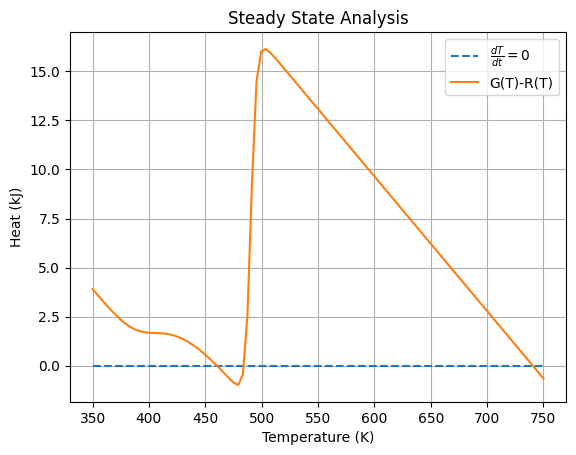

In [5]:
# Steady state temperature analysis
T_range = np.linspace(350, 750, 100)

energy_balance = np.zeros(T_range.shape[0])

plt.plot(T_range, energy_balance, '--', label=r"$\frac{dT}{dt}=0$")

for i, val in enumerate(T_range):
    energy_balance[i] = solve_heat([val])[0]

plt.plot(T_range, energy_balance, label="G(T)-R(T)")
plt.title("Steady State Analysis")
plt.xlabel("Temperature (K)")
plt.ylabel("Heat (kJ)")
plt.grid(which='both', axis='both')
plt.legend()

In [6]:
# T_s evaluation
T_s = fsolve(solve_heat, [460])[0]

T_s

460.31823156995324

## Steady State Concentrations

In [7]:
# steady state outlet
C_As = solve_C_A(T_s)
C_Ss = solve_C_S(T_s)
C_As, C_Ss

(0.21167013796294581, 2.9999920948240835)

## Steady state conversion

In [8]:
# A conversion
1 - C_As / C_A0

0.9507743865202452

In [9]:
# S conversion
1 - C_Ss / C_S0

2.6350586388446118e-06

# Linearization

In [10]:
# matrices around U
A = sympy.matrices.Matrix([
    [
        f_C_A.diff(C_A).subs({C_A: C_As, T: T_s}), 
        f_C_A.diff(C_S).subs({C_A: C_As, T: T_s}), 
        f_C_A.diff(T).subs({C_A: C_As, T: T_s}),
    ],
    [
        f_C_S.diff(C_A).subs({C_S: C_Ss, T: T_s}), 
        f_C_S.diff(C_S).subs({C_S: C_Ss, T: T_s}), 
        f_C_S.diff(T).subs({C_S: C_Ss, T: T_s}),
    ],
    [
        f_T.diff(C_A).subs({C_A: C_As, C_S: C_Ss, T: T_s, U: U_s, T_0: T_0s}), 
        f_T.diff(C_S).subs({C_A: C_As, C_S: C_Ss, T: T_s, U: U_s, T_0: T_0s}), 
        f_T.diff(T).subs({C_A: C_As, C_S: C_Ss, T: T_s, U: U_s, T_0: T_0s}),
    ],
])

b_around_U = sympy.matrices.Matrix([
    [f_C_A.diff(U).subs({C_A: C_As, T: T_s})],
    [f_C_S.diff(U).subs({C_S: C_Ss, T: T_s})],
    [f_T.diff(U).subs({C_A: C_As, C_S: C_Ss, T: T_s, U: U_s, T_0: T_0s})],

])

c = sympy.matrices.Matrix([
    [0, 0, 1],
])

d = 0

In [11]:
# matrices around T_0
b_around_T_0 = sympy.matrices.Matrix([
    [f_C_A.diff(T_0).subs({C_A: C_As, T: T_s})],
    [f_C_S.diff(T_0).subs({C_S: C_Ss, T: T_s})],
    [f_T.diff(T_0).subs({C_A: C_As, C_S: C_Ss, T: T_s, U: U_s, T_0: T_0s})],

])

In [12]:
system_parameter_dict = {
    'parameters': {
        'k_10': 4e14,
        'E_1': 1.28e5,  
        'k_20': 1e84,
        'E_2': 8e5,
        'H_1': -45400,
        'H_2': -3.2e5,
        'rho': 12.4,
        'C_p': 254,
        'A': 5.3,
        'T_c': 373,
        'V': 4000,
    },
    'inlet': {
        'F_A0': 1075,
        'F_S0': 750,
        'F_B0': 1275,
        'F': F,
        'v_0': v_0,
        'C_A0': C_A0, 
        'C_B0': C_B0, 
        'C_S0': C_S0, 
    },
    'steady_state': {
        'T_0': T_0s,
        'U': U_s,
        'T': T_s,
        'C_A': C_As,
        'C_S': C_Ss,
    },
    'state_space': {
        'around_U':{
            'A': np.array(A, dtype=float).tolist(),
            'b': np.array(b_around_U, dtype=float).tolist(),
            'c': np.array(c, dtype=float).tolist(),
            'd': d,
        },
        'around_T_0': {
            'A': np.array(A, dtype=float).tolist(),
            'b': np.array(b_around_T_0, dtype=float).tolist(),
            'c': np.array(c, dtype=float).tolist(),
            'd': d,
        }
    }
}

In [13]:
with open('system_parameter_dict.json', 'w') as _write_file:
    json.dump(system_parameter_dict, _write_file, indent=4)

In [14]:
solve(Eq(0, f_T.subs({C_A: C_As, C_S: C_Ss, T: T_s})), U)

[1701.43204992452*T_0 - 682931.140469052]

432.536309928867

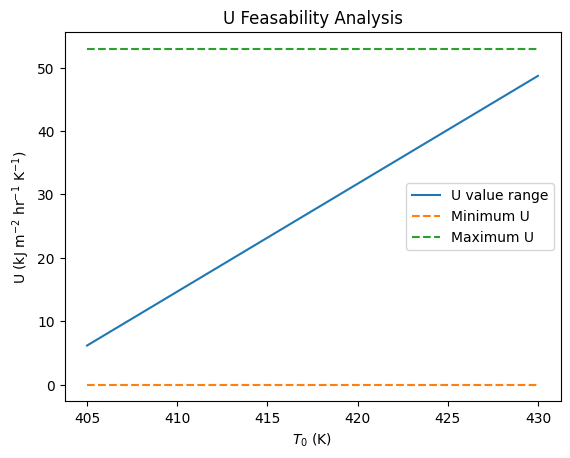

In [15]:
U_of_T_0 = lambda T_0: 1701.43204992447 * T_0 - 682931.140469038

T_0_range = np.linspace(410-5, 410+20, 100)

plt.plot(T_0_range, U_of_T_0(T_0_range)/1e3, label="U value range")
plt.plot(T_0_range, np.zeros(T_0_range.shape[0]), '--', label="Minimum U")
plt.plot(T_0_range, 53*np.ones(T_0_range.shape[0]), '--', label="Maximum U")
plt.xlabel(r"$T_0$ (K)")
plt.ylabel(r"U (kJ m$^{-2}$ hr$^{-1}$ K$^{-1}$)")
plt.legend()
plt.title("U Feasability Analysis")

largest_T_0 = fsolve(lambda T: U_of_T_0(T) - 53e3, [430])[0]
largest_T_0

# Plots for Problem 6

In [16]:
with open('solutions.json', 'r') as _file:
    data = json.load(_file)
_file.close()
with open('system_parameter_dict.json', 'r') as _file:
    params = json.load(_file)
_file.close()

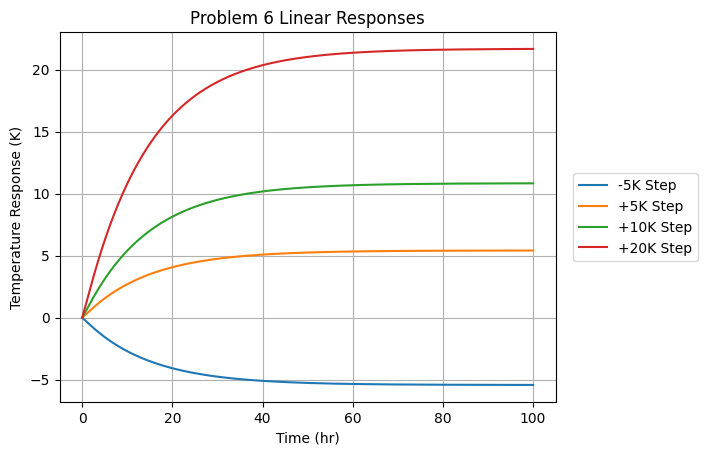

In [17]:
plt.plot(data['minus_5K_step']['t'], data['minus_5K_step']['y'], label="-5K Step")
plt.plot(data['plus_5K_step']['t'], data['plus_5K_step']['y'], label="+5K Step")
plt.plot(data['plus_10K_step']['t'], data['plus_10K_step']['y'], label="+10K Step")
plt.plot(data['plus_20K_step']['t'], data['plus_20K_step']['y'], label="+20K Step")
plt.legend(loc="right", bbox_to_anchor=[1.3, 0.5])
plt.title("Problem 6 Linear Responses")
plt.xlabel("Time (hr)")
plt.ylabel("Temperature Response (K)")
plt.grid(which='both', axis='both')

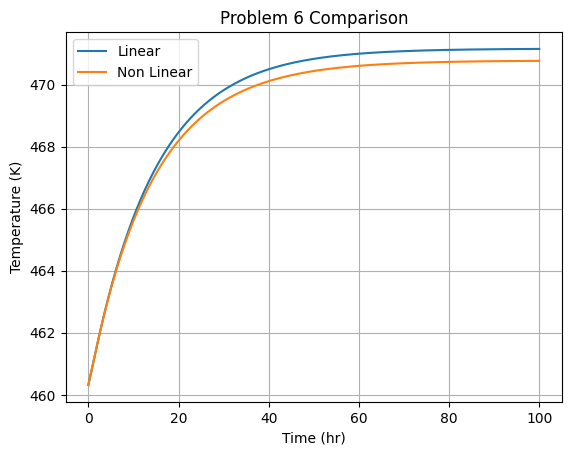

In [18]:
plt.plot(data['plus_10K_step']['t'], np.array(data['plus_10K_step']['y']) + params['steady_state']['T'], label="Linear")
plt.plot(data['non_linear_10K_step']['t'], np.array(data['non_linear_10K_step']['y'])[:,2], label="Non Linear")
plt.legend()
plt.title("Problem 6 Comparison")
plt.xlabel("Time (hr)")
plt.ylabel("Temperature (K)")
plt.grid(which='both', axis='both')